# Dataset Visualization Notebook (musicnn)

---

Author: **Malek Ibrahim**

This notebooks seeks to create a TSNE plot of the preset dataset in their timbral space (musicnn timbral features). General steps are outlined below:

1. Load the preset dataset file
1. Categorize the presets
1. Prepare the DataFrame
1. Obtain the TSNE 2D embeddings from the higher-dimensional timbral features
1. Plot the results!

## Imports

---

For this script, we will need Pytorch to load the dataset, scikit-learn for the TSNE plot functionality, and also plotly to visualize the results.

In [1]:
import torch
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import sys;sys.path.append('..')
from sklearn.manifold import TSNE
from src.utils import *

## Load the Preset Dataset

---

Load the preset from the saved `.pt` file and inspect its structure.

In [2]:
dataset = torch.load('preset_dataset_musicnn.pt')

In [3]:
dataset.keys()

dict_keys(['preset_names', 'parameters', 'parameters_names', 'mapped_parameter_names', 'raw_audio', 'musicnn_features'])

In [4]:
dataset['preset_names']

['Default',
 'MT Tailwhip Organ (2)',
 'Super Jumper',
 'Nice Filter Sweep',
 'Chillin R2D2',
 'Deep Drop In',
 'Enter the Twirl',
 'Water Love',
 'Pulse Drop',
 'Phasing Island Bass',
 'Mono Pulse Bass',
 '08-15 Bass',
 'Classic Saw Bass',
 'Funky Mod Bass',
 'Ultra Deep Bass',
 'Basic Pad',
 'Apollo Pad',
 'Pulse Drop Pad',
 'Self Destroy',
 'Big Lead',
 'Double Chorus Trancer',
 'Super Funky Lead',
 'Startup',
 'Ugly One',
 'Disharmonic feedback',
 'Slow Phaser',
 'Eso Drops',
 'Dark Roads',
 'Mellow LoFi Lead',
 'Crystal Drops',
 'Dream Arp',
 'FN-Bassliner-BAS',
 'FN-Dark Bass II-BAS',
 'FN-Flow Bass-BAS',
 'FN-High Noise-BAS',
 'FN-Wobblelike Bass-BAS',
 'FN-Dark Bass-BAS',
 'FN-Nostalgic Bass-BAS',
 'FN-C64ish Bass',
 'FN-Basslover',
 'FN-Bass Wobbler-BAS',
 'FN-Wobblebass-BAS',
 'FN-Dark Night-PAD',
 'FN-Analog Feeling-PAD',
 'FN-Blubberfeld-PAD',
 'FN-Noisia-PAD',
 'FN-Darpesh Pad-PAD',
 'FN-Restless Night-PAD',
 'FN-Analog Pad-PAD',
 'FN-RollinSun-PAD',
 'FN-Flowing Filter-PA

In [5]:
# we need to convert the preset names to a categorical variable in order to group the points in the scatter plot
categorized_names = {name: categorize_name(name) for name in dataset['preset_names']}

In [6]:
categorized_names

{'Default': 'Miscellaneous/Other',
 'MT Tailwhip Organ (2)': 'Organs',
 'Super Jumper': 'Miscellaneous/Other',
 'Nice Filter Sweep': 'Miscellaneous/Other',
 'Chillin R2D2': 'Miscellaneous/Other',
 'Deep Drop In': 'Miscellaneous/Other',
 'Enter the Twirl': 'Miscellaneous/Other',
 'Water Love': 'Miscellaneous/Other',
 'Pulse Drop': 'Miscellaneous/Other',
 'Phasing Island Bass': 'Bass',
 'Mono Pulse Bass': 'Bass',
 '08-15 Bass': 'Bass',
 'Classic Saw Bass': 'Bass',
 'Funky Mod Bass': 'Bass',
 'Ultra Deep Bass': 'Bass',
 'Basic Pad': 'Miscellaneous/Other',
 'Apollo Pad': 'Miscellaneous/Other',
 'Pulse Drop Pad': 'Miscellaneous/Other',
 'Self Destroy': 'Miscellaneous/Other',
 'Big Lead': 'Leads',
 'Double Chorus Trancer': 'Miscellaneous/Other',
 'Super Funky Lead': 'Leads',
 'Startup': 'Miscellaneous/Other',
 'Ugly One': 'Miscellaneous/Other',
 'Disharmonic feedback': 'Miscellaneous/Other',
 'Slow Phaser': 'Miscellaneous/Other',
 'Eso Drops': 'Miscellaneous/Other',
 'Dark Roads': 'Miscellan

## Create the Pandas DataFrame for Input to the TSNE Plot

---

We need to put our dataset into a form that is friendly for the TSNE plot. Specifically, we plan to put everything into an ordered table, a Pandas DataFrame.  

In [7]:
# initialize a pandas dataframe
df = pd.DataFrame()

In [8]:
# add a column for the preset names
df['preset_name'] = dataset['preset_names']

# add a column for the categorized preset names
df['categorized_name'] = [categorized_names[name] for name in dataset['preset_names']]

# add a column for the MFCC features (should we normalize these?)
df['musicnn_features'] = [torch.tensor(x['C3']) for x in dataset['raw_audio']] # for now, use C3, we can try other notes and see if we get different results.

# normalize the musicnn features
df['musicnn_features'] = [normalize_zero_to_one(x) for x in df['musicnn_features']]

/var/folders/1h/qfss5lwn3jzdb7t8r1y63r9r0000gn/T/ipykernel_99566/4225653848.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df['musicnn_features'] = [torch.tensor(x['C3']) for x in dataset['raw_audio']] # for now, use C3, we can try other notes and see if we get different results.


In [9]:
# visualize the first few rows of df
df.head(5)

,preset_name,categorized_name,musicnn_features
0,Default,Miscellaneous/Other,"[tensor(0.4408), tensor(0.4421), tensor(0.4469..."
1,MT Tailwhip Organ (2),Organs,"[tensor(0.5646), tensor(0.5630), tensor(0.5615..."
2,Super Jumper,Miscellaneous/Other,"[tensor(0.5280), tensor(0.4980), tensor(0.4606..."
3,Nice Filter Sweep,Miscellaneous/Other,"[tensor(0.4137), tensor(0.4308), tensor(0.4433..."
4,Chillin R2D2,Miscellaneous/Other,"[tensor(0.5109), tensor(0.5257), tensor(0.5489..."


In [10]:
len(df)

367

In [11]:
# remove all rows in the df that are miscellaneous or other
df_filtered = df[df['categorized_name'] != 'Miscellaneous/Other']
len(df_filtered)

227

In [12]:
# reset the index of the dataframe
df_filtered = df_filtered.reset_index(drop=True)

In [13]:
len(df_filtered)

227

In [14]:
# visualize the filtered dataframe
df_filtered.head(5)

,preset_name,categorized_name,musicnn_features
0,MT Tailwhip Organ (2),Organs,"[tensor(0.5646), tensor(0.5630), tensor(0.5615..."
1,Phasing Island Bass,Bass,"[tensor(0.4993), tensor(0.4975), tensor(0.4957..."
2,Mono Pulse Bass,Bass,"[tensor(0.4996), tensor(0.4984), tensor(0.4972..."
3,08-15 Bass,Bass,"[tensor(0.6288), tensor(0.6255), tensor(0.6221..."
4,Classic Saw Bass,Bass,"[tensor(0.6375), tensor(0.6376), tensor(0.6377..."


### Obtain the TSNE Transformed Data

---

Here we will initialize a TSNE object and apply a `fit_transform` to obtain a dimensionally reduced vector from the high dimensional input data.

In [15]:
# we need to first convert the MFCC embeddings from torch format to numpy format for the TSNE algorithm
embeddings =  np.stack(df['musicnn_features'])
embeddings.shape

(367, 132030)

In [16]:
# obtain the filtered embeddings
filtered_embeddings = np.stack(df_filtered['musicnn_features'])
filtered_embeddings.shape

(227, 132030)

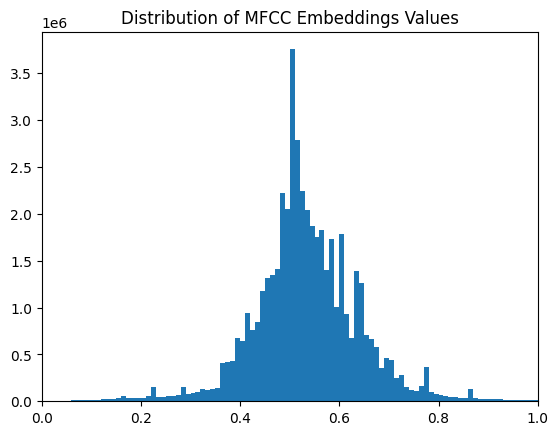

In [17]:
# Before we obtain the TSNE embeddings, let's first visualize the distribution of the MFCC embeddings
plt.hist(embeddings.flatten(), bins=100)
plt.xlim([0,1])
plt.title('Distribution of MFCC Embeddings Values')
plt.show()

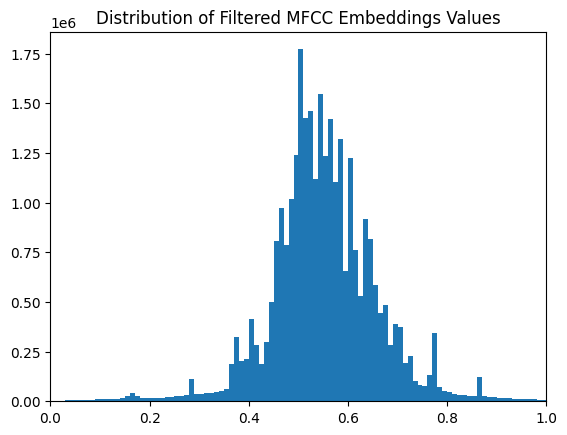

In [18]:
# Let's also visualize the filtered embeddings distribution
plt.hist(filtered_embeddings.flatten(), bins=100)
plt.xlim([0,1])
plt.title('Distribution of Filtered MFCC Embeddings Values')
plt.show()

In [19]:
# get the TSNE transform
transformed_data = generate_tsne(embeddings)

In [20]:
filtered_transformed_data = generate_tsne(filtered_embeddings, perplexity=8)

In [21]:
# inspect the transformed data
transformed_data.shape

(367, 2)

In [22]:
# create an x and y column in the dataframe
df['x'] = [transformed_data[i][0] for i in range(len(transformed_data))]
df['y'] = [transformed_data[i][1] for i in range(len(transformed_data))]

In [23]:
# create a filtered x and filtered y column in the dataframe
df_filtered['x'] = [filtered_transformed_data[i][0] for i in range(len(filtered_transformed_data))]
df_filtered['y'] = [filtered_transformed_data[i][1] for i in range(len(filtered_transformed_data))]

## Create the TSNE Plot

---

Let's now use Plotly to visualize these embeddings!

In [25]:
## Create the TSNE Plot with plotly
fig = px.scatter(df_filtered, x='x', y='y', color='categorized_name',hover_data=['preset_name', 'categorized_name'], width=800, height=800)

# add a legend
fig.update_layout(showlegend=True)

# add a title
fig.update_layout(title='TSNE Visualization of Preset musicnn Embeddings')

# add a hover label
fig.update_traces(hovertemplate='Preset Name: %{customdata[0]}<br>Categorized Name: %{customdata[1]}')

# obtain the data bounds
x_min = np.min(filtered_transformed_data[:, 0])*1.2
x_max = np.max(filtered_transformed_data[:, 0])*1.2
y_min = np.min(filtered_transformed_data[:, 1])*1.2
y_max = np.max(filtered_transformed_data[:, 1])*1.2

# add some extra info to the plot
fig.update_layout(
    width=800,
    height=800,
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    legend_title='Preset Categories',
    xaxis=dict(range=[x_min, x_max]),
    yaxis=dict(range=[y_min, y_max]),
)   

# show the plot
fig.show()

In [26]:
# save the plotly figure as an svg
fig.write_image('tsne-raw-audio-baseline.svg')